In [99]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os 
from os.path import join as pjoin
import glob
import numpy as np
from scipy import linalg as LA
import cv2
# from PIL import Image
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['figure.figsize'] = (10, 7)
mpl.rcParams['image.cmap'] = 'inferno'

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
#     plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
def resize(img, shape):
    return cv2.resize(img, (imgshape[1], imgshape[0]))

def stack_images(matrices, k=5, imgshape=np.array([480, 640])):
    """
        matrices -- (N, *imgshape, k) array,
                    where N is the number of `matrices`,
                          k is the number of images in each `matrix`
    """
    k = min(matrices[0].shape[-1], k)
    N = len(matrices)
    num_cols, num_rows = N, 1
    matrices_ = []
    if len(imgshape) == 2:
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(2,0,1)[:k]
            matrices_.append(M)
    else:
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(3,0,1,2)[:k]
            matrices_.append(M)
    for k_ in range(k):
        for i in range(N):
            plt.subplot(num_rows, num_cols, i+1)
            imshow(matrices_[i][k_], 'gray')
        plt.show()

In [101]:
# imgdir = 'data'
# img_name = 'marker_cut_rgb_512'
# filename = pjoin(imgdir, '{}.png'.format(img_name))
# img = imread(filename) 
# imshow(gray(img), 'gray')

# With help of cv2

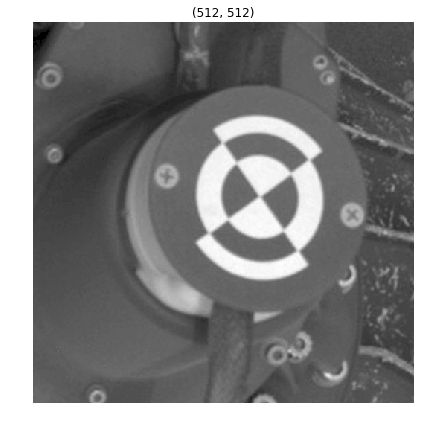

In [102]:
import cv2
import numpy as np
import math

imgdir = 'data'
img_name = 'marker_cut_rgb_512'
filename = pjoin(imgdir, '{}.png'.format(img_name))

src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    # Check if image is loaded fine
if src is None:
    print ('Error opening image!')
    print ('Usage: hough_lines.py [image_name -- default ' + default_file + '] \n')

imshow(src, 'gray')

## Edge detection

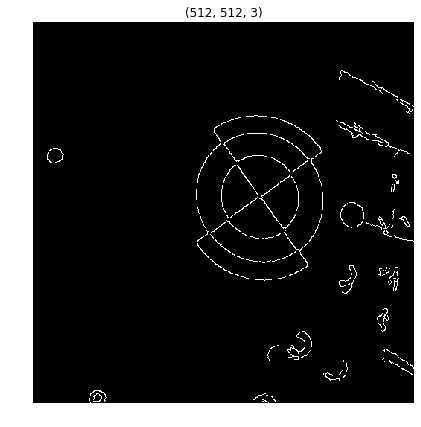

In [106]:
dst = cv2.Canny(src, 50, 200, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
imshow(cdst, 'gray')

## After applying Hough space

2


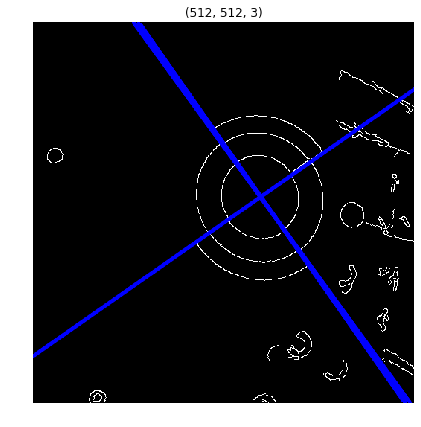

In [110]:
lines = cv2.HoughLines(dst, 1, np.pi / 180, 87, None, 0, 0)

print(len(lines))

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
        
imshow(cdst, 'gray')

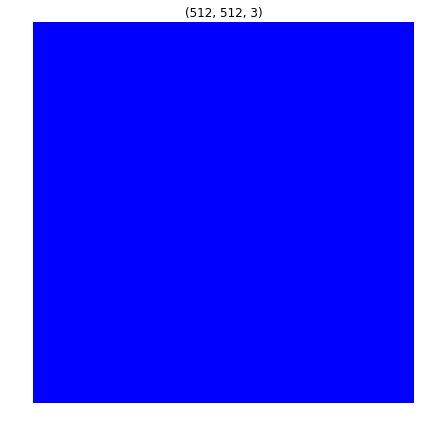

In [88]:
# cv2.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)



---

# Test on a single image

In [5]:
mpl.rcParams['figure.figsize'] = (10,10)
imgdir = 'data_img'
img_name = 'img2'
filename = pjoin(imgdir, '{}.jpg'.format(img_name))
img = gray(imread(filename))
# cv2.imwrite('img2_gray.jpg', img)
img = img[700:1200,900:1400]
# imshow(img, 'gray')

## SVD

Rank of the low matrix:  150
Rank of the original matrix 500


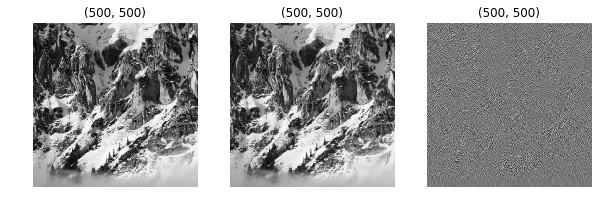

In [6]:
U, S, VT = LA.svd(img, full_matrices=False)

ks = [150]
for k in ks:
    Sigma = np.eye(k)*S[:k]
    img_low = U[:,:k].dot(Sigma).dot(VT[:k,:])
    print('Rank of the low matrix: ', np.linalg.matrix_rank(img_low))
    print('Rank of the original matrix', np.linalg.matrix_rank(img))
    stack_images((img.reshape(-1,1), img_low.reshape(-1,1), (img-img_low).reshape(-1,1)), imgshape=img.shape)
#     filename = pjoin(imgdir, 'img_low_{:02}.jpg'.format(k))
#     cv2.imwrite(filename, img_low)
# quality = LA.norm(img) - LA.norm(img-img_low)
# size = os.stat(filename).st_size

## Robust PCA

Rank of the low matrix:  249
Rank of the original matrix 500


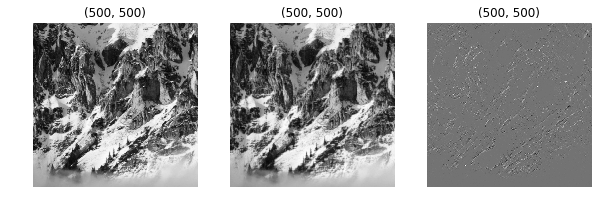

In [8]:
rpca = R_pca(img)
L, S = rpca.fit()

print('Rank of the low matrix: ', np.linalg.matrix_rank(rpca.L))
print('Rank of the original matrix', np.linalg.matrix_rank(img))
stack_images((img.reshape(-1,1), L.reshape(-1,1), S.reshape(-1,1)), imgshape=img.shape)

---

# Test on a video (a list of frames)

In [9]:
mall_dataset_path = 'data_highway_fr_5/'
color = False
imgpaths = sorted(glob.glob(pjoin(mall_dataset_path, '*.jpg')))
imgshape = np.array([240, 320])
n = 10
if color:
    imgshape = np.array([*imgshape, 3])
    M = resize(imread(imgpaths[0]), imgshape).reshape((-1,1))
    for imgpath in imgpaths[1:n]:
        img = resize(imread(imgpath), imgshape)
        img_vec = img.reshape((-1,1))
        M = np.hstack((M, img_vec))
else:
    M = resize(gray(imread(imgpaths[0])), imgshape).reshape((-1,1))
    for imgpath in imgpaths[1:n]:
        img = resize(gray(imread(imgpath)), imgshape)
        img_vec = img.reshape((-1,1))
        M = np.hstack((M, img_vec))
# stack_images((M,), k=1, imgshape=imgshape)
# M.shape

## RPCA

Rank of L = 10


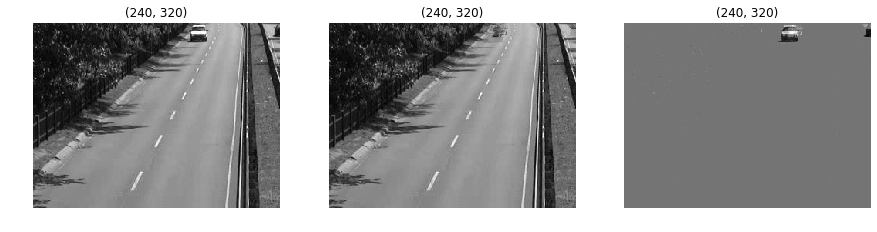

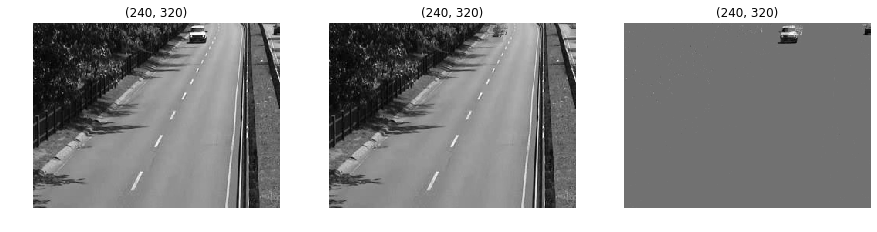

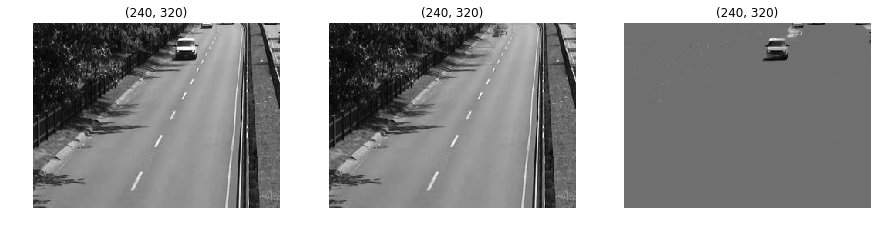

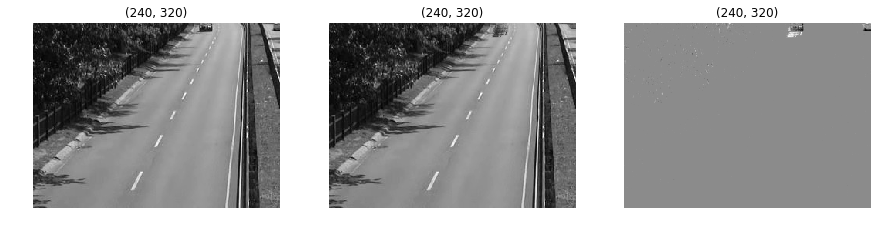

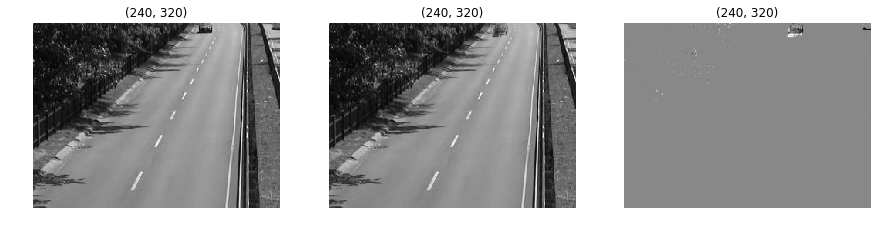

In [10]:
mpl.rcParams['figure.figsize'] = (15,15)
mu = 0.0001
lmbda = 0.01
rpca = R_pca(M, mu=mu, lmbda=lmbda)
L, S = rpca.fit()
print('Rank of L = {}'.format(np.linalg.matrix_rank(L)))
if color:
    L = L.astype(np.uint8)
    S = np.maximum(S, 0).astype(np.uint8)
stack_images((M, L, S), k=5, imgshape=imgshape)

## SVD

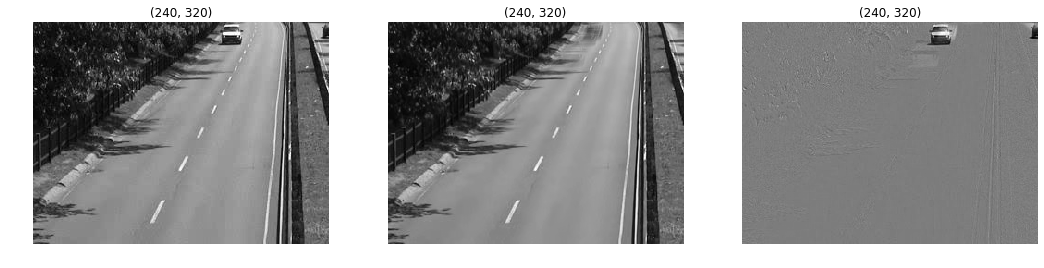

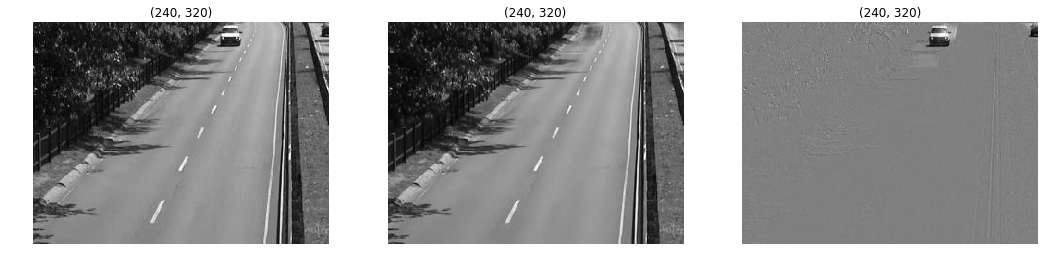

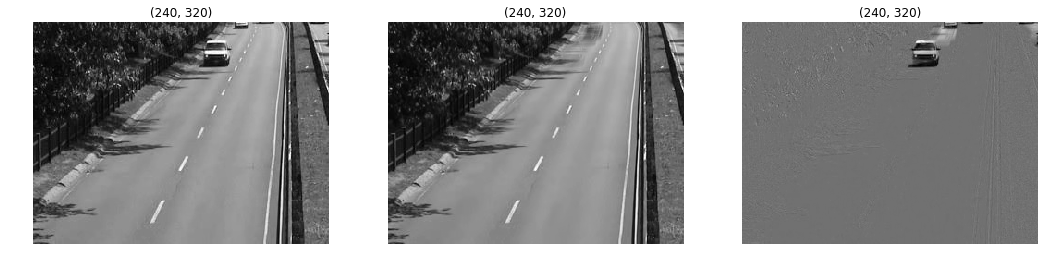

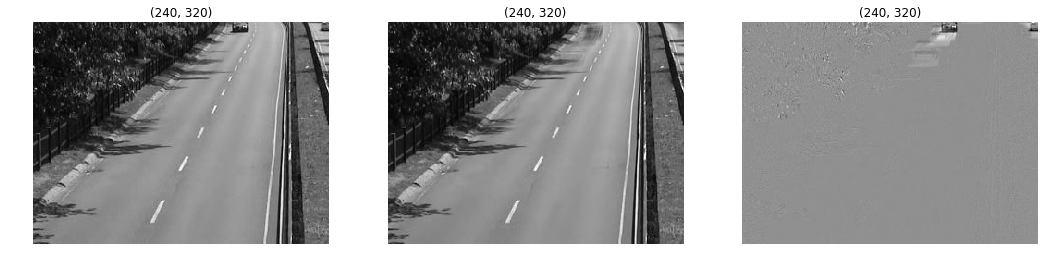

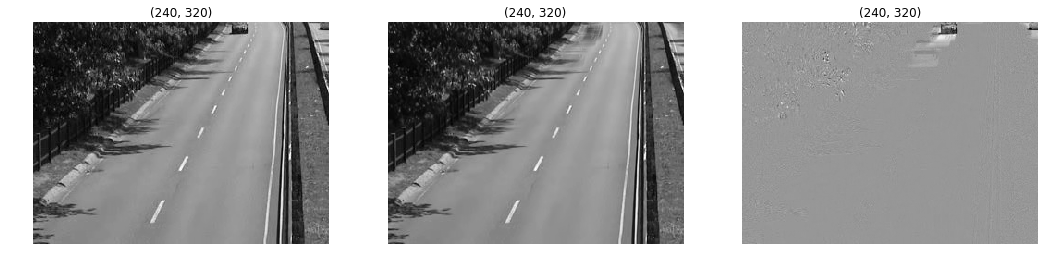

In [11]:
mpl.rcParams['figure.figsize'] = (18,18)
U, S, VT = LA.svd(M, full_matrices=False)
k = 1
Sigma = np.eye(k)*S[:k]

L = U[:,:k].dot(Sigma).dot(VT[:k,:])
if color:
    # L = np.round(np.minimum(np.maximum(L, 0), 255)).astype(np.uint8)
    # L = np.minimum(np.maximum(L, 0), 255).astype(np.uint8)
    # S = np.maximum(M-L,0)
    # L = L.astype(np.uint8)
    L = np.round(np.minimum(np.maximum(L, 0), 255)).astype(np.uint8)
S = M-L

stack_images((M, L, S), k=5, imgshape=imgshape)

## Just the mean (which is the same as the result of SVD (when restricting to rank k =1)

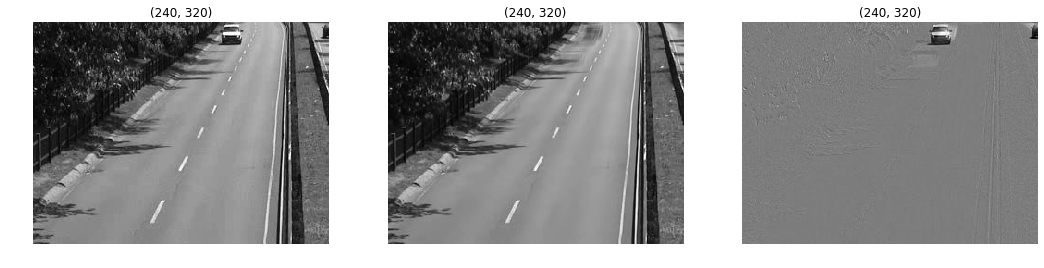

In [12]:
L = np.mean(M,1,keepdims=True) * np.ones_like(M)
S = M-L
stack_images((M,L,S), k=1, imgshape=imgshape)

## Robust Orthonormal Subspace Learning from https://github.com/tjof2/robustpca

In [13]:
print(M.shape)

(76800, 10)


In [ ]:
# mall_dataset_path = 'data_highway_fr_5/'
# color = False
# imgpaths = sorted(glob.glob(pjoin(mall_dataset_path, '*.jpg')))
# imgshape = np.array([240, 320])
# n = 10
# if color:
#     imgshape = np.array([*imgshape, 3])
#     M = resize(imread(imgpaths[0]), imgshape).reshape((-1,1))
#     for imgpath in imgpaths[1:n]:
#         img = resize(imread(imgpath), imgshape)
#         img_vec = img.reshape((-1,1))
#         M = np.hstack((M, img_vec))
# else:
#     M = resize(gray(imread(imgpaths[0])), imgshape).reshape((-1,1))
#     for imgpath in imgpaths[1:n]:
#         img = resize(gray(imread(imgpath)), imgshape)
#         img_vec = img.reshape((-1,1))
#         M = np.hstack((M, img_vec))
# print(M.shape)

In [ ]:
# imgpaths = sorted(glob.glob(pjoin(mall_dataset_path, '*.jpg')))
# imgshape = np.array([120, 160])
# n_ROSL = len(imgpaths)
# print(n_ROSL)

mall_dataset_path = 'data_highway_fr_5/'
# color = False
imgpaths = sorted(glob.glob(pjoin(mall_dataset_path, '*.jpg')))
imgshape = np.array([240, 320])

for imgpath in imgpaths[1:10]:
    img = resize(gray(imread(imgpath)), imgshape)
    img_vec = img.reshape((-1,1))
    M = np.hstack((M, img_vec))
print(M.shape)

In [ ]:
full_rosl = pyrosl.ROSL(
    method = 'full',
    rank = 1,
    reg = 1,
    verbose = False)
print(M.shape)
full_loadings = full_rosl.fit_transform(M.astype(np.float64))
L = np.dot(full_loadings, full_rosl.components_)
# print(full_loadings.shape, L.shape, M_chunk.shape)
stack_images((M, L, M-L), k=5, imgshape=imgshape)

In [ ]:
print("RPCA used %d images, ROSL used %d images!"%(n, n_ROSL))

# Test on faces 

In [ ]:
def imread2(imgpath):
    return np.array(Image.open(imgpath))

yale_dataset_path = 'data_yalefaces'
imgpaths = sorted(glob.glob(pjoin(yale_dataset_path, 'subject11*')))
imgshape = np.array([243,320])
# imgshape = np.array([120, 160])
n = len(imgpaths)
# img = resize(gray(imread(imgpaths[0])), imgshape)
img = imread2(imgpaths[0])
M = img.reshape((-1,1))
for imgpath in imgpaths[1:n]:
#     img = resize(gray(imread(imgpath)), imgshape)
    img = imread2(imgpath)
    img_vec = img.reshape((-1,1))
    M = np.hstack((M, img_vec))
    
# return_images(M, k=n, imgshape=imgshape)

In [ ]:
rpca = R_pca(M)
L, S = rpca.fit()

mpl.rcParams['figure.figsize'] = (15,15)
stack_images((M, L, S), k=1, imgshape=imgshape)

In [ ]:
full_rosl = pyrosl.ROSL(
        method = 'full',
        verbose = False)
full_loadings = full_rosl.fit_transform(M.astype(np.float64))
L = np.dot(full_loadings, full_rosl.components_)
# print(full_loadings.shape, L.shape, M_chunk.shape)
stack_images((M, L, M-L), k=1, imgshape=imgshape)

In [ ]:
U, S, VT = LA.svd(M, full_matrices=False)
k = 3
Sigma = np.eye(k)*S[:k]
L = U[:,:k].dot(Sigma).dot(VT[:k,:])
stack_images((M, L, M-L), k=1, imgshape=imgshape)

---

# Test on data points

## 2D

In [ ]:
import numpy as np
import scipy.stats as stats
from scipy import linalg as LA
from matplotlib import pyplot as plt
import matplotlib as mpl

def sample_mvn2D_from_1D(mu1=0, mu2=0, sigma1=1, sigma2=1, rho=0, N=100):
    x0 = np.random.normal(size=N)
    y0 = np.random.normal(size=N)
    x = mu1 + sigma1*x0
    y = mu2 + sigma2*(rho*x0 + np.sqrt(1-rho**2)*y0)
    A = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return A

def visualize2D(A, color='blue'):
    A = A.reshape((-1,2))
    plt.scatter(A[:,0], A[:,1], color=color)
    lmax, lmin = np.max(A), np.min(A)
    plt.xlim(lmin,lmax)
    plt.ylim(lmin,lmax)

def visualizeEVec(V):
    V = np.array(V)
    plt.scatter(0,0, c='k')
    plt.scatter(V[0,:], V[1,:], c='red')

def PCA(A, out=False):
    N = A.shape[0]
    mean_point = np.mean(A, 0, keepdims=True)
    A0 = A - mean_point
    C = A0.T.dot(A0)
    if out:
        print('Covariance matrix:\n{}'.format(C))
    l, v = LA.eig(C)
    l = l.real
    ids = np.argsort(-l)
    lambdas, V = l[ids], v[:,ids]
    principal_components = list(V.T)
    if out:
        print('Eigenvalues & eigenvectors')
        for i, (l, v) in enumerate(list(zip(lambdas, principal_components))):
            print('l_{} = {:.2f}\tv_{} = {}'.format(i, l, i, v.flatten()))
    return principal_components

def projectPoints(A, v):
    mean_point = np.mean(A, 0, keepdims=True)
    A0 = A - mean_point
    P = v.dot(v.T) / (v.T.dot(v))
    PA = (P.dot(A0.T)).T + mean_point
    return PA

In [ ]:
def PCA_fit(A):
    mean_point = np.mean(A, 0, keepdims=True)
    pc = PCA(A, out=False)
    v1 = pc[0].reshape(-1,1)
    m1, m2 = mean_point.flatten()
    slope = v1[1] / v1[0]
    intercept = m2 - m1 * slope
    return slope, intercept

def RPCA_fit(A, mu=None, lmbda=None, visualze=False):
    rpca = R_pca(A, mu=mu, lmbda=lmbda)
    L, S = rpca.fit(iter_print=np.nan)
    pc = PCA(rpca.L, out=False)
    v1 = pc[0].reshape(-1,1)
    m1, m2 = np.mean(L, 0)
    slope = v1[1] / v1[0]
    intercept = m2 - m1 * slope
    if visualze:
        visualize2D(L)
        visualize2D(S)
        plt.show()
    return slope, intercept

def ROSL_fit(A, visualze=False):
    full_rosl = pyrosl.ROSL(
        method = 'full',
        rank = 1,
        reg = 0.1,
        verbose = False)
    full_loadings = full_rosl.fit_transform(A.astype(np.float64))  
    L = np.dot(full_loadings, full_rosl.components_)
    S = A - L
    pc = PCA(L, out=False)
    v1 = pc[0].reshape(-1,1)
    m1, m2 = np.mean(L, 0)
    slope = v1[1] / v1[0]
    intercept = m2 - m1 * slope
    if visualze:
        visualize2D(L, color="blue")
        visualize2D(S, color='red')
        plt.show()
    return slope, intercept


def errors(s1, intercept1, s2, intercept2, err='sqr'):
    if err == 'sqr':
        return float((s1 - s2)**2), float((intercept1 - intercept2)**2)
    elif err == 'abs':
        return float(np.abs(s1 - s2)), float(np.abs(intercept1 - intercept2))

def draw_func(f, xlmin=0, xlmax=1, N=1000, color='k'):
    xs = np.linspace(xlmin, xlmax, N)
    try:
        ys = f(xs)
    except:
        ys = [f(x) for x in xs]
    plt.plot(xs, ys, color)

In [ ]:
N = 500
mu1, mu2 = 1, 2
sigma1, sigma2 = 4, 9
rho = 0.999

# x_noise = np.random.normal(size=N)
# y_noise = np.random.normal(size=N)


mpl.rcParams['figure.figsize'] = (5,5)
A = sample_mvn2D_from_1D(mu1, mu2, sigma1, sigma2, rho, N)
A_noise = sample_mvn2D_from_1D(25, 10, 4, 4, N=int(0.01*N))
A_noise2 = sample_mvn2D_from_1D(25, -10, 4, 4, N=int(0.02*N))
A = np.vstack((A, A_noise))

s = sigma2/sigma1
intercept = mu2 - mu1 * s
f_true = lambda x: s * x + intercept # y - slope * x - intercept = 0
draw_func(f_true, xlmin=A.min(), xlmax=A.max())
visualize2D(A)
plt.show()

In [ ]:
s_PCA, intercept_PCA = PCA_fit(A)
f_pred = lambda x: s_PCA * x + intercept_PCA # y - slope * x - intercept = 0
draw_func(f_pred, xlmin=A.min(), xlmax=A.max(), color='orange')
draw_func(f_true, xlmin=A.min(), xlmax=A.max())
visualize2D(A)
plt.show()

slope_squared_error, intercept_squared_error = errors(s, intercept, s_PCA, intercept_PCA, 'sqr')
print(slope_squared_error, intercept_squared_error)

In [ ]:
s_RPCA, intercept_RPCA = RPCA_fit(A, lmbda=0.1)
f_pred = lambda x: s_RPCA * x + intercept_RPCA # y - slope * x - intercept = 0
draw_func(f_pred, xlmin=A.min(), xlmax=A.max(), color='orange')
draw_func(f_true, xlmin=A.min(), xlmax=A.max())
visualize2D(A)
plt.show()

slope_squared_error, intercept_squared_error = errors(s, intercept, s_RPCA, intercept_RPCA, 'sqr')
print(slope_squared_error, intercept_squared_error)

In [ ]:
s_ROSL, intercept_ROSL = ROSL_fit(A)
f_pred = lambda x: s_ROSL * x + intercept_ROSL # y - slope * x - intercept = 0
draw_func(f_pred, xlmin=A.min(), xlmax=A.max(), color='orange')
draw_func(f_true, xlmin=A.min(), xlmax=A.max())
visualize2D(A)
plt.show()

slope_squared_error, intercept_squared_error = errors(s, intercept, s_ROSL, intercept_ROSL, 'sqr')
print(slope_squared_error, intercept_squared_error)

In [ ]:
N = 100
mu1, mu2 = 1, 2
sigma1, sigma2 = 4, 9
rho = 0.999
s = sigma2/sigma1
intercept = mu2 - mu1 * s

noise_Ns = np.arange(30)
sqr_errors_PCA = []
sqr_errors_RPCA = []
sqr_errors_ROSL = []

A0 = sample_mvn2D_from_1D(mu1, mu2, sigma1, sigma2, rho, N)
mu = np.prod(A0.shape) / (4 * np.sum(np.power(A0, 2)))
mu = 0.1
lmbda = 0.1
print('RPCA params: mu = {:.3f}, lambda = {:.3f}'.format(mu, lmbda))
for noise_N in noise_Ns:
    A_noise = sample_mvn2D_from_1D(25, 10, 4, 4, N=noise_N)
    A = np.vstack((A0, A_noise))
    s_PCA, intercept_PCA = PCA_fit(A)
    s_RPCA, intercept_RPCA = RPCA_fit(A, mu=mu, lmbda=lmbda)
    s_ROSL, intercept_ROSL = ROSL_fit(A)
    sqr_errors_PCA.append(errors(s, intercept, s_PCA, intercept_PCA, 'sqr'))
    sqr_errors_RPCA.append(errors(s, intercept, s_RPCA, intercept_RPCA, 'sqr'))
    sqr_errors_ROSL.append(errors(s, intercept, s_ROSL, intercept_ROSL, 'sqr'))
sqr_errors_PCA = np.array(sqr_errors_PCA)
sqr_errors_RPCA = np.array(sqr_errors_RPCA)
sqr_errors_ROSL = np.array(sqr_errors_ROSL)

mpl.rcParams['figure.figsize'] = (13,6)

plt.title('Slope squared error')
plt.plot(noise_Ns, sqr_errors_PCA[:,0])
plt.plot(noise_Ns, sqr_errors_RPCA[:,0])
plt.plot(noise_Ns, sqr_errors_ROSL[:,0])
plt.legend(['PCA', 'RPCA', 'ROSL'])
plt.show()

plt.title('Intercept squared error')
plt.plot(noise_Ns, sqr_errors_PCA[:,1])
plt.plot(noise_Ns, sqr_errors_RPCA[:,1])
plt.plot(noise_Ns, sqr_errors_ROSL[:,1])
plt.legend(['PCA', 'RPCA', 'ROSL'])
plt.show()

In [ ]:
# visualize2D(A)
# s_RPCA, intercept_RPCA = RPCA_fit(A, lmbda=lmbda, visualze=True)
# f_pred = lambda x: s2 * x + intercept2 # y - slope * x - intercept = 0
# draw_func(f_pred, xlmin=A.min(), xlmax=A.max(), color='orange')
# draw_func(f_true, xlmin=A.min(), xlmax=A.max())
# visualize2D(A)
# plt.show()